In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/Vera/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Load data
schars = pd.read_csv('simpsons_characters.csv')
sepisodes = pd.read_csv('simpsons_episodes.csv')
slines = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False, warn_bad_lines=False, low_memory=False)
locations = pd.read_csv('simpsons_locations.csv', error_bad_lines=False, warn_bad_lines=False, low_memory=False)

## Підготуємо та дослідимо дані

### Додамо дані про кількість персонажів у епізоді, кількість локацій та кількість слів

In [3]:
sepisodes['num_characters'] = 0
sepisodes['words_count'] = 0
sepisodes['num_locations'] = 0

for id in sepisodes['id']:
    num_characters = len(slines[slines['episode_id'] == id].dropna().character_id.drop_duplicates())
    words_count = slines[slines['episode_id'] == id].dropna().word_count.sum()
    num_locations = len(slines[slines['episode_id'] == id].dropna().location_id.drop_duplicates())
    sepisodes.set_value(sepisodes['id'] == id, 'num_characters', num_characters)
    sepisodes.set_value(sepisodes['id'] == id, 'words_count', words_count)
    sepisodes.set_value(sepisodes['id'] == id, 'num_locations', num_locations)
    
sepisodes[['id', 'num_characters', 'words_count', 'num_locations']].head(5)

,id,num_characters,words_count,num_locations
0,10,40,2521.0,28
1,12,33,2788.0,15
2,14,27,2646.0,18
3,17,28,2764.0,14
4,19,14,2688.0,13


### Додамо дані про головного героя епізоду, базуючих на кількості сказанних слів

In [4]:
sepisodes['main_character'] = 0

for id in sepisodes['id']:
    main_character = slines[slines['episode_id'] == id].dropna().groupby(['raw_character_text'])['word_count'].sum().sort_values(ascending=False).keys()
    if (len(main_character) == 0):
        sepisodes.set_value(sepisodes['id'] == id, 'main_character', np.NaN)
    else:
        sepisodes.set_value(sepisodes['id'] == id, 'main_character', main_character[0])

In [5]:
sepisodes[['id', 'main_character']].head(5)

,id,main_character
0,10,Homer Simpson
1,12,Sideshow Bob
2,14,Bart Simpson
3,17,C. Montgomery Burns
4,19,Homer Simpson


### Додамо дані про голону локацію епізоду

In [6]:
sepisodes['main_location'] = 0

for id in sepisodes['id']:
    main_location = slines[slines['episode_id'] == id].dropna().groupby(['raw_location_text'])['word_count'].sum().sort_values(ascending=False).keys()
    if (len(main_location) == 0):
        sepisodes.set_value(sepisodes['id'] == id, 'main_location', np.NaN)
    else:
        sepisodes.set_value(sepisodes['id'] == id, 'main_location', main_location[0])

In [7]:
sepisodes[['id', 'main_location']].head(5)

,id,main_location
0,10,Sapphire Lounge
1,12,TV Studio
2,14,CLASSROOM
3,17,Simpson Home
4,19,MINIATURE GOLF COURSE


## Кореляція мож кількостю переглядів (діалогів, кількості серії і тд) від рейтингу сезону

/Users/Vera/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


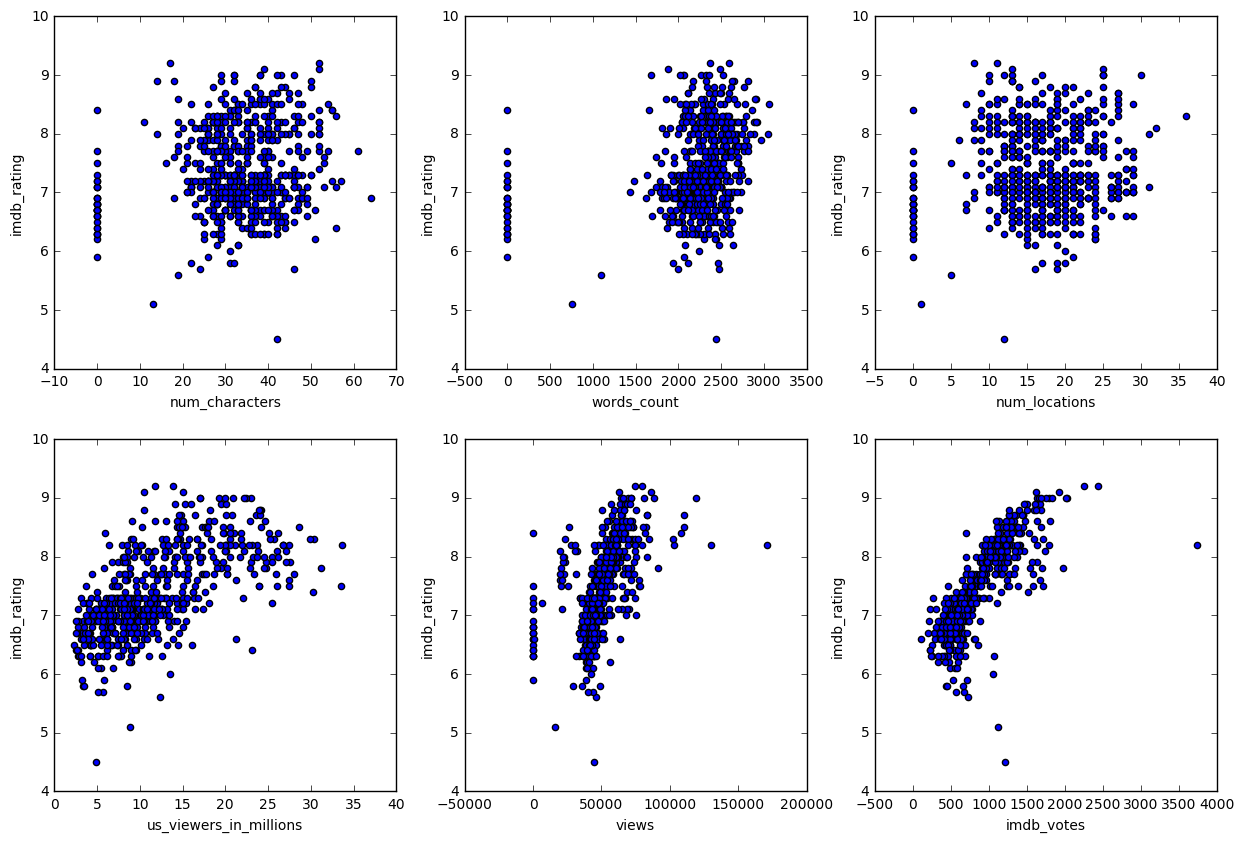

In [11]:
episodes_data = sepisodes[['num_characters', 'words_count', 'num_locations', 'us_viewers_in_millions','views','imdb_votes','imdb_rating']]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for idx, feature in enumerate(episodes_data.columns[:-1]):
    episodes_data.plot(feature, "imdb_rating", subplots=True, kind="scatter", ax=axes[idx / 3, idx % 3])

обучение 

1. нормировать данные
2. линейная регрессия

In [22]:
data = sepisodes[['num_characters', 'words_count', 'num_locations', 'main_character', 'main_location','us_viewers_in_millions','views','imdb_votes','imdb_rating']]

In [36]:
data_train = pd.get_dummies(data, columns=['main_character', 'main_location']).dropna()

In [37]:
train_X,test_X = train_test_split(data_train.ix[:, data_train.columns != 'imdb_rating'], test_size=0.1, random_state=42)
train_y,test_y = train_test_split(data_train['imdb_rating'], test_size=0.1, random_state=42)

In [38]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=200, seed=42).fit(train_X, train_y)

In [39]:
predicted_test =  xgb_model.predict(test_X);
mae = mean_absolute_error(test_y, predicted_test)
print('Cередня похибка передбачення (MAE):', mae)

Cередня похибка передбачення (MAE): 0.224139194489


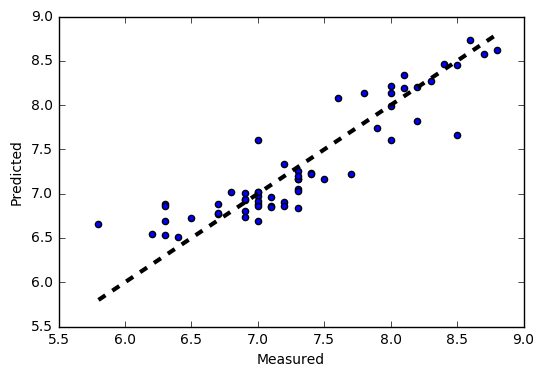

In [40]:
fig, ax = plt.subplots()
ax.scatter(test_y, predicted_test)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

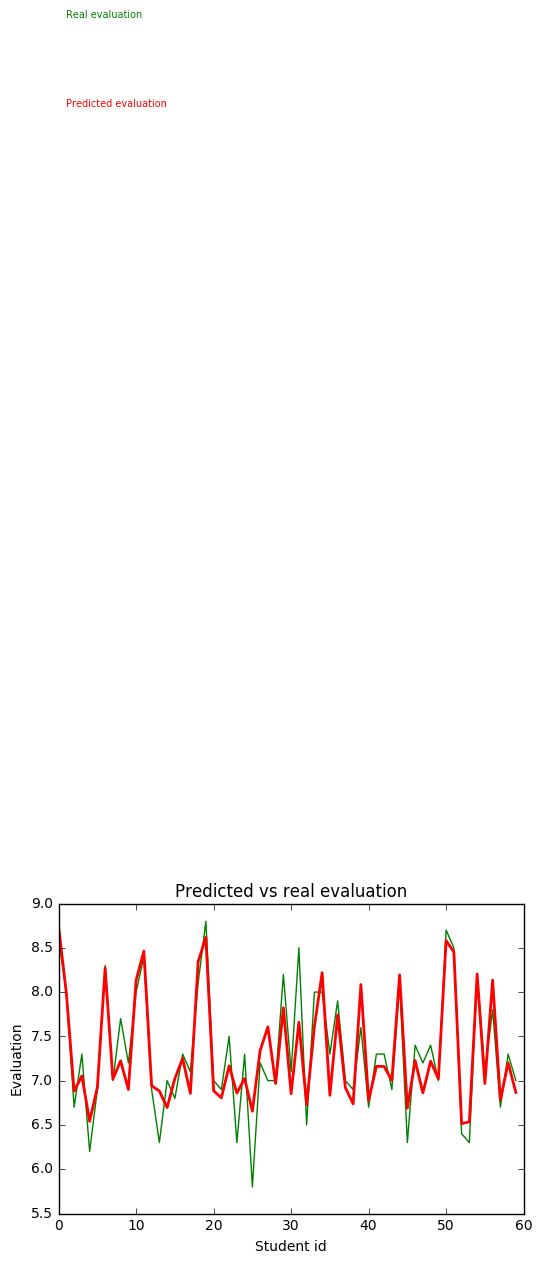

In [41]:
plt.plot(test_y.values, color="green", linewidth=1)
plt.plot(predicted_test, color="red", linewidth=2)
plt.xlabel('Student id')
plt.ylabel('Evaluation')
plt.title('Predicted vs real evaluation')
plt.text(1,19,'Real evaluation', color="green", fontsize=7)
plt.text(1,18,'Predicted evaluation', color="red", fontsize=7)
plt.show()

In [42]:
feature_importance = xgb_model.booster().get_fscore()

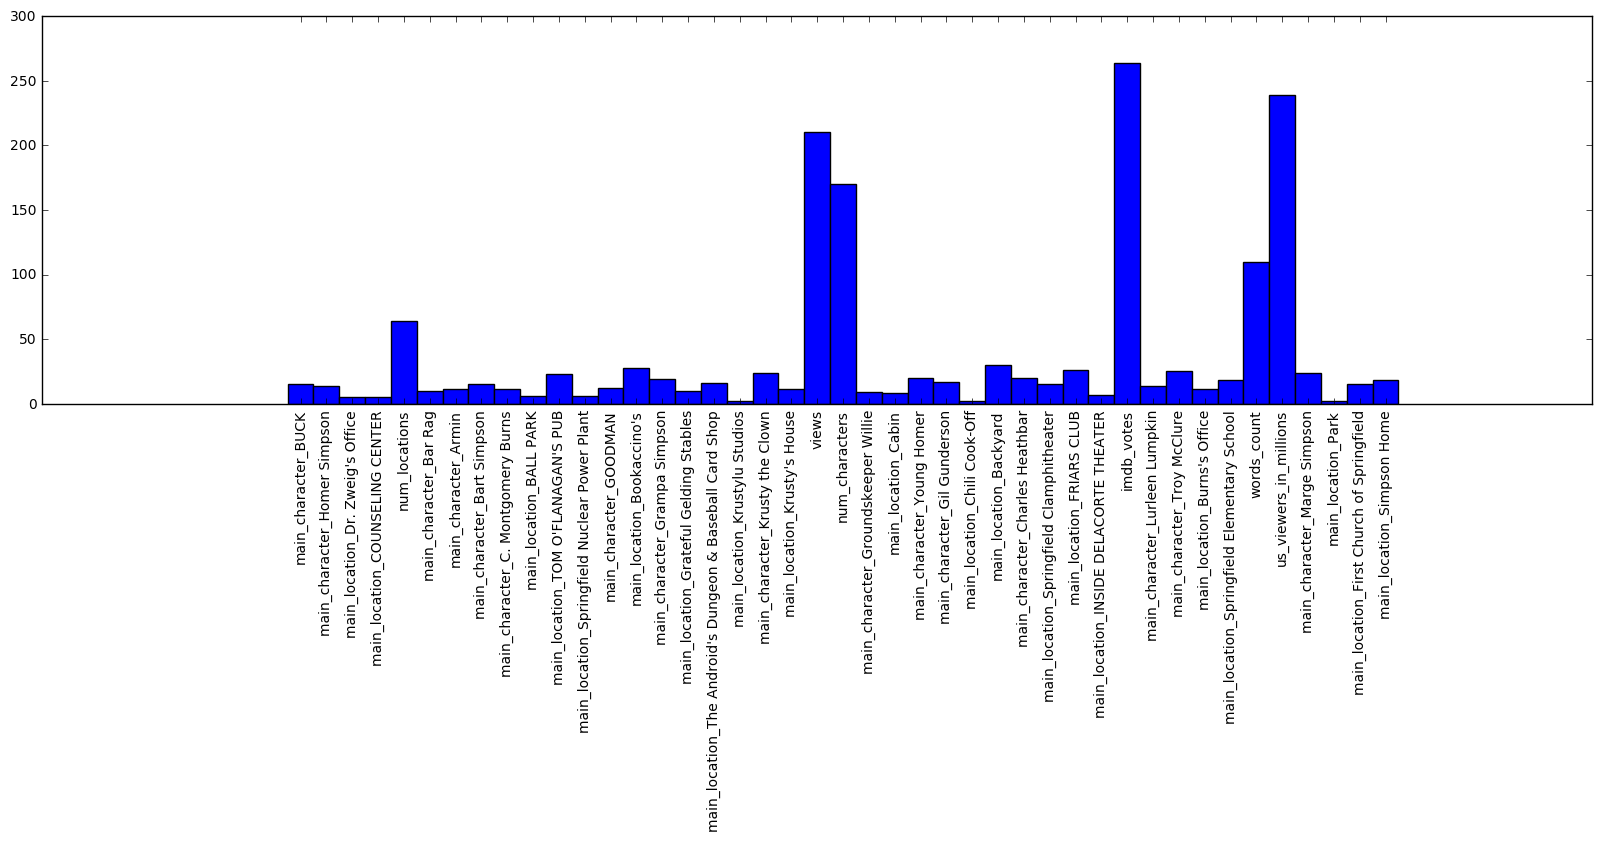

In [43]:
X = np.arange(len(feature_importance))
plt.figure(figsize=(20,5))
plt.bar(X, feature_importance.values(), align='center', width=1)
plt.xticks(X, feature_importance.keys(), rotation=90)
plt.show()

In [44]:
def train_models(trees, maes):
    for tree in trees:
        model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=tree, seed=42).fit(train_X, train_y)
        mae = mean_absolute_error(test_y, model.predict(test_X))
        maes.append(mae)
        print('кількість дерев:', tree, '| середня похибка передбачення:', mae)
        print('----------------------------------------------------------')

In [ ]:
trees = np.arange(10, 301, 5)
maes = []
train_models(trees, maes)

кількість дерев: 10 | середня похибка передбачення: 4.10273339669
----------------------------------------------------------
кількість дерев: 15 | середня похибка передбачення: 3.17958412886
----------------------------------------------------------
кількість дерев: 20 | середня похибка передбачення: 2.4629762125
----------------------------------------------------------
кількість дерев: 25 | середня похибка передбачення: 1.90889946938
----------------------------------------------------------
кількість дерев: 30 | середня похибка передбачення: 1.47791139603
----------------------------------------------------------
кількість дерев: 35 | середня похибка передбачення: 1.14305479844
----------------------------------------------------------
кількість дерев: 40 | середня похибка передбачення: 0.890510377884
----------------------------------------------------------
кількість дерев: 45 | середня похибка передбачення: 0.697467567126
----------------------------------------------------------

In [ ]:
plt.plot(trees,maes, color="red", alpha=0.7, linewidth=2.0)
plt.ylabel('Mean average error')
plt.xlabel('Trees')
plt.show()